In [25]:
import requests
from PIL import Image
import io
import base64
from IPython.display import display
import pandas as pd
from pathlib import Path
import wikipedia
import urllib.request
import tqdm
import nature_go_client
import matplotlib.pyplot as plt
import sys
import rembg


In [26]:
# Nature Go parameters
NG_USERNAME = input()
NG_PASSWORD = input()

# Stable Diffusion parameters
SD_HOST = 'http://nature-go.edouardleurent.com'
STEPS = 20
WIDTH = 1024
HEIGHT = 1024
# SAMPLER = 'DPM++ 2M Karras'
PROMPT = "{commonNames} {scientificNameWithoutAuthor}, herbarium illustration, 19th century, transactions of the Botanical Society of London"


## Retrieve species with missing images through Nature go API

In [27]:
client = nature_go_client.NatureGoClient(username=NG_USERNAME, password=NG_PASSWORD)
client.login()

In [28]:
species_list = client.get_labeled_species(illustration=False, limit=10)
print(f'Found {len(species_list)} species')
species_list = pd.DataFrame(species_list)
species_list

,id,commonNames,scientificName,scientificNameWithoutAuthor,genus,family,occurences_cdf,descriptions,illustration,illustration_transparent,wikipedia_image_url,illustration_url,display_name,total_observations
0,1258,"[Stemless carline thistle, Carline thistle, Dw...",Carlina acaulis L.,Carlina acaulis,Carlina,Compositae,0.290414,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Stemless carline thistle,2
1,4,"[Perle Von Nurnberg, Hen and chicken plant, Du...",Echeveria gibbiflora DC.,Echeveria gibbiflora,Echeveria,Crassulaceae,0.004274,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Perle Von Nurnberg,2
2,12803,"[Green Alkanet, Bird's-eye, Evergreen bugloss]",Pentaglottis sempervirens (L.) Tausch ex L.H.B...,Pentaglottis sempervirens,Pentaglottis,Boraginaceae,0.436973,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Green Alkanet,1
3,10632,"[Grass of Parnassus, Bog star, Marsh parnassia]",Parnassia palustris L.,Parnassia palustris,Parnassia,Celastraceae,0.394695,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Grass of Parnassus,1
4,6246,"[Poppy anemone, Anemone, Spanish marigold]",Anemone coronaria L.,Anemone coronaria,Anemone,Ranunculaceae,0.208328,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Poppy anemone,1
5,8910,[Alpine toadflax],Linaria alpina (L.) Mill.,Linaria alpina,Linaria,Plantaginaceae,0.129342,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Alpine toadflax,1
6,7562,"[Spider Wort, Branched St. Bernard's-lily, Spi...",Anthericum ramosum L.,Anthericum ramosum,Anthericum,Asparagaceae,0.121253,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Spider Wort,1
7,11076,"[Common Gladiolus, Eastern gladiolus, Cornflag]",Gladiolus communis L.,Gladiolus communis,Gladiolus,Iridaceae,0.059216,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Common Gladiolus,1
8,11844,"[Poppy, Welsh Poppy]",Papaver cambricum L.,Papaver cambricum,Papaver,Papaveraceae,0.017265,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Poppy,1
9,5,[],Echeveria coccinea (Cav.) DC.,Echeveria coccinea,Echeveria,Crassulaceae,NaN,[],None,None,,http://nature-go.edouardleurent.com/static/img...,Echeveria coccinea,1


## Run generation with ComfyUI

In [29]:
# Import workflows
sys.argv = ['']
from illustration_workflows import txt2img_workflow
from illustration_workflows import controlnet_workflow
comfyui_path = txt2img_workflow.find_path("ComfyUI")
rembg_session = rembg.new_session(model_name="isnet-general-use")


def run_txt2img_worflow(positive_prompt, negative_prompt):
    import random
    random.seed(len(positive_prompt))
    result = txt2img_workflow.main(positive_prompt=positive_prompt, negative_prompt=negative_prompt)
    illustration = Image.open(Path(comfyui_path) / 'output' / result['illustration']['ui']['images'][0]['filename'])
    illustration_transparent = rembg.remove(illustration, session=rembg_session)
    return illustration, illustration_transparent

def display_images(*images):
    _, axes = plt.subplots(1, len(images), figsize=(5*len(images), 5), squeeze=False)
    for i, image in enumerate(images):
        axes.flat[i].imshow(image)
        axes.flat[i].axis('off')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

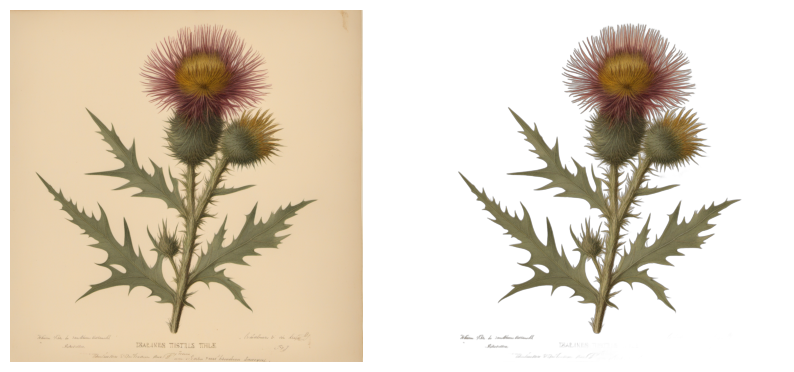

In [30]:
species = species_list.iloc[0]
prompt = PROMPT.format(commonNames=', '.join(species.commonNames), scientificNameWithoutAuthor=species.scientificNameWithoutAuthor)
illustration, illustration_transparent = run_txt2img_worflow(positive_prompt=prompt, negative_prompt='')
display_images(illustration, illustration_transparent)

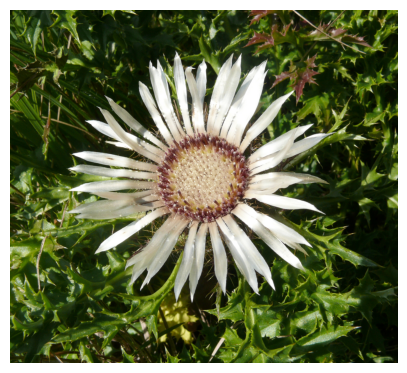

In [31]:
def fetch_wikipedia_image(scientific_name):
    page = wikipedia.page(scientific_name)
    img_url =  page.images[0]
    with urllib.request.urlopen(img_url) as url:
        img = Image.open(io.BytesIO(url.read()))
        return img

reference_image = fetch_wikipedia_image(species.scientificNameWithoutAuthor)
display_images(reference_image)


In [35]:
reference_image_name = f"reference_{species.scientificNameWithoutAuthor}.png"
reference_image.save(Path(comfyui_path) / "input" / reference_image_name)

import torch
torch.cuda.empty_cache()

def run_controlnet_worflow(positive_prompt, negative_prompt, reference_image_name):
    import random
    random.seed(len(positive_prompt))
    result = controlnet_workflow.main(positive_prompt=positive_prompt, negative_prompt=negative_prompt, control_image=reference_image_name)
    illustration = Image.open(Path(comfyui_path) / 'output' / result['illustration']['ui']['images'][0]['filename'])
    mask = Image.open(Path(comfyui_path) / 'output' / result['controlnet_mask']['ui']['images'][0]['filename'])
    illustration_transparent = rembg.remove(illustration, session=rembg_session)
    return illustration, illustration_transparent, mask

illustration, illustration_transparent, mask = run_controlnet_worflow(positive_prompt=prompt, negative_prompt='', reference_image_name=reference_image_name)
display_images(reference_image, mask, illustration, illustration_transparent)

  0%|          | 0/20 [00:00<?, ?it/s]

RuntimeError: Tensor on device cuda:0 is not on the expected device meta!

## Upload result to Nature Go API

In [36]:
confirm_send = input()
if confirm_send == 'y':
    client.update_species_image(species_id=species.id, image=illustration, image_name='illustration')
    client.update_species_image(species_id=species.id, image=illustration_transparent, image_name='illustration_transparent')